In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib import font_manager
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys
import torch

sys.path.append('..')
from data_utils import *

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *

plt.style.use('../sci_style.py')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

# Load Data

In [3]:
# chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

# W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))
# lyaps = pd.read_pickle(os.path.join(chaotic_net_path, "lyaps_long.pkl"))
# full_signals = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_net_signals_long.pkl"))

In [4]:
# N = list(full_signals.values())[0].shape[2]
# T = list(full_signals.values())[0].shape[1]
# dt = 0.01
# tau = 0.1

In [5]:
# save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/chaotic_nets_multirun'

In [6]:
# num_runs = 10

# g_vals = list(full_signals.keys())
# W_vals = np.zeros((num_runs, N, N))

# # for g in g_vals:

# t_span = [0, T*dt]
# t_eval = np.arange(t_span[0], t_span[1], dt)

# run_rets = []

# for i in range(num_runs):
#     print("="*40)
#     print(f"RUN {i}")
#     print("="*40)
#     W = np.random.randn(N, N)/np.sqrt(N)
#     W_vals[i] = W
#     signals = {}
#     print("Simulating signals...")
#     for g in tqdm(g_vals):
#         x0 = np.random.randn(N)
#         sol = scipy.integrate.solve_ivp(lambda t, x: rnn(t, x, W=W, tau=tau, g=g), t_span=t_span, t_eval=t_eval, y0=x0)
#         signals[g] = sol.y.T
    
#     print("Signals are simulated!")
    
#     lyaps = {}
#     for key, signal in signals.items():
#         print("-"*20)
#         print(f"g = {key}")
#         print("-"*20)
#         Js = np.zeros((signal.shape[0], N, N))
#         batch_size = 500
#         num_batches = int(np.ceil(signal.shape[0]/batch_size))
#         print("Computing Jacobians..")
#         for batch_num in tqdm(range(num_batches)):
#             start_ind = batch_num*batch_size
#             end_ind = np.min([(batch_num + 1)*batch_size, signal.shape[0]])
#             Js[start_ind:end_ind] = rnn_jacobian(signal[start_ind:end_ind], W, tau, dt, N, use_torch=True, device='cuda').cpu().numpy()
#         print("Computing Lyaps...")
#         lyaps[key] = compute_lyaps(Js, dt, verbose=True)
#     ret = dict(
#         W=W,
#         dt=dt,
#         tau=tau,
#         signals=signals,
#         lyaps=lyaps
#     )
#     pd.to_pickle(ret, os.path.join(save_dir, f"RUN_{i}"))

In [7]:
# mp_args = dict(
#     # ----------------------
#     # MULTIPROCESSING ARGUMENTS
#     # ----------------------
#     USE_TORCH=False,
#     USE_CUDA=False,
#     DTYPE='torch.DoubleTensor',
#     NUM_WORKERS=3,
# #     NUM_WORKERS=4,
#     USE_LOGGING=True,
#     LOG_DIR="/om2/user/eisenaj/code/shell_scripts/chaotic",
#     LOG_NAME='mp_chaotic',
#     LOG_LEVEL=logging.DEBUG,
#     RESULTS_DIR='/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/chaotic_nets_multirun',
    
#     # ==========================
#     # CHAOTIC NET ARGUMENTS
#     # ==========================
#     dt=dt,
#     tau=tau,
#     N=N,
#     T=T,
#     batch_size=500,
#     num_batches=int(np.ceil(T/batch_size)),
#     g_vals=g_vals,
#     num_runs=18,
# )
# data_processing_args_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/data_processing_args"
# data_processing_path = os.path.join(data_processing_args_dir, "chaotic_multirun_args")
# pd.to_pickle(mp_args, data_processing_path)
# mp_args = argparse.Namespace(**mp_args)

In [8]:
# if not mp_args.USE_CUDA:
#     os.system(f"sbatch --gres=gpu:0 --ntasks=1 --cpus-per-task={int(mp_args.NUM_WORKERS) + 2} --mem={int(mp_args.NUM_WORKERS*100) + 10}GB /om2/user/eisenaj/code/shell_scripts/chaotic/mp_chaotic.sh {data_processing_path}")
# else:
#     os.system(f"sbatch --gres=gpu:{mp_args.NUM_WORKERS} /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")

In [9]:
# os.system("squeue -u eisenaj")

In [10]:
# os.system("scancel 30533918")

# Linear Systems

In [11]:
def set_smallest_eigenvalue_real_part(A,lam):

    #lam is the desired maximum eigenvalue
    assert lam < 0, print('Eigenvalue must be negative')

    #get current eigenvalues
    e,v = np.linalg.eig(A)
    largest_eig = np.max(np.real(e))
    I = np.eye(len(e))
  
    #return scaled 
    return A - largest_eig*I + lam*I

def do_one_sde_run(n, lam_awake, lam_anesthesia, awake = 1, random_seed=42):

    np.random.seed(random_seed)

    A = np.random.normal(0,1/np.sqrt(n),(n,n))

    if awake == 1:
        #pick the stability parameter
        lam = lam_awake

        # Define the Weiner process    
        dW = np.sqrt(dt) * np.random.randn(N,n)

        #define systems matrix
        A_awake = set_smallest_eigenvalue_real_part(A,lam)

    else:

        lam = lam_anesthesia

        dW = np.sqrt(dt) * np.random.randn(N,n)

        A_anesthesia = set_smallest_eigenvalue_real_part(A,lam)


    # Define the function f(x)
    def f(x,lam):
        if awake == 1:
            return A_awake @ x
        else:
            return A_anesthesia @ x


    # Define the function g(x)
    def g(x):
        return 1

    # Initialize the x array
    x = np.zeros((N,n))
    x[0] = np.zeros(n)

    # Simulate the stochastic differential equation
    for i in range(1, N):
        x[i] = x[i-1] + f(x[i-1],lam) * dt + g(x[i-1]) * dW[i]

    return x

In [12]:
use_torch=True
device = 'cuda'

In [13]:
NUM_RUNS = 20
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/linear_noise_multirun'

In [14]:
class ParameterGrid:
    def __init__(self, window_vals, matrix_size_vals, r_vals):
        self.window_vals = window_vals
        self.matrix_size_vals = matrix_size_vals
        self.r_vals = r_vals

In [15]:
# Define the parameters
# N = int(1e5)
N = 20000
n = 100
T = 40.0
dt = T / N
x0 = 0.0

lams = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]

parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([10, 20, 50, 100, 200, 300, 500, 750, 1000]),
    r_vals=np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000])
)


prediction_time = 5000
transient = 2000

num_samples = 10

for i in range(NUM_RUNS):
    if not os.path.exists(os.path.join(save_dir, f"RUN_{i}")):
        print("="*40)
        print(f"RUN {i}")
        print("="*40)

        print("Simulating...")
        trajs = {}
        for lam in lams:
            x_1 = do_one_sde_run(n, lam_awake = lam, lam_anesthesia = 0, awake = 1, random_seed=42 + i)
            trajs[lam] = x_1
        #         plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam}$')
        #     plt.legend()
        #     plt.show()
        indices = np.random.choice(np.arange(n), num_samples, replace=False)
        for key in trajs.keys():
            trajs[key] = trajs[key][:, indices]
        print("Simulated!")

        signals = trajs

        mean_stab_curve = True
        true_vals = lams
        keys = np.array(lams)
        key_inds = np.arange(len(lams))

        print("Computing DeLASE...")
        results = []
        iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))
        for window in parameter_grid.window_vals:
            for matrix_size in parameter_grid.matrix_size_vals:
                delases = {}
                exp_variances = {}
        #         train_signals = []
                test_signals = {}
                for key, signal in signals.items():
                    train_signal = signal[transient:transient + window]
                    test_signal = signal[transient + window:transient + window + prediction_time]
                    delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=use_torch, device=device, dtype='torch.DoubleTensor')
                    delase.to('cpu')
                    if use_torch:
                        exp_variances[key] = delase.cumulative_explained_variance.cpu().double()
                    else:
                        exp_variances[key] = delase.cumulative_explained_variance
                    delases[key] = delase
        #             train_signals.append(train_signal)
                    test_signals[key] = test_signal
                for r in parameter_grid.r_vals:
                    if r <= np.min([delase.n*delase.p for delase in delases.values()]):
                        stab_curves = {}
                        AICs = {}
                        for key, delase in delases.items():
                            delase.to('cuda')
                            delase.compute_havok_dmd(r=r)
                            delase.get_stability(max_freq=500, max_unstable_freq=125)

                            AICs[key] = compute_AIC(delase, test_signals[key])
                            if use_torch:
                                stab_curves[key] = delase.stability_params.cpu()
                            else:
                                stab_curves[key] = delase.stability_params

                        if use_torch:
                            exp_variances = np.array([delase.cumulative_explained_variance[r-1].cpu().numpy() for delase in delases.values()])
                        else:
                            exp_variances = np.array([delase.cumulative_explained_variance[r-1] for delase in delases.values()])

                        results.append(dict(
                            window=window,
                            matrix_size=matrix_size,
                            r=r,
                            exp_variances=exp_variances,
                            AICs=AICs,
                            stab_curves=stab_curves,
                        ))

                    iterator.update()
        iterator.close()

        results = pd.DataFrame(results)
        results_dict = {}
        for key in lams:
            ret_temp = results.copy()
            ret_temp = ret_temp.drop('AICs', axis=1)
            ret_temp = ret_temp.drop('stab_curves', axis=1)
            ret_temp = ret_temp.drop('exp_variances', axis=1)
            ret_temp['AIC'] = results.AICs.apply(lambda x: x[key])
            ret_temp['stab_curves'] = results.stab_curves.apply(lambda x: x[key])
            ret_temp = ret_temp.set_index((['window', 'matrix_size', 'r']))
            results_dict[key] = ret_temp


        pd.to_pickle(results_dict, os.path.join(save_dir, f"RUN_{i}"))

# Load Linear Systems Data

In [16]:
top_percent = 0.1

In [17]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/linear_noise_multirun'

In [18]:
lams = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]

In [19]:
rets = []
for f in tqdm(os.listdir(save_dir)):
    rets.append(pd.read_pickle(os.path.join(save_dir, f)))

  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
ret_means = np.zeros(len(lams))
ret_mean_counts = np.zeros(len(lams))
for ret in tqdm(rets):
    window, matrix_size, r, all_results = combine_grid_results(ret)
    
    print(matrix_size, r)
    
    for i, key in enumerate(lams):
        stab_curve = ret[key].loc[(window, matrix_size, r)].stab_curves
        
        ret_means[i] += stab_curve[:int(top_percent*len(stab_curve))].sum()
        ret_mean_counts[i] += int(top_percent*len(stab_curve))
        
ret_means = ret_means/ret_mean_counts

  0%|          | 0/20 [00:00<?, ?it/s]

10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10


In [21]:
ret_means_se = np.zeros(len(lams))
ret_mean_se_counts = np.zeros(len(lams))
for ret in tqdm(rets):
    window, matrix_size, r, all_results = combine_grid_results(ret)
    
    for i, key in enumerate(lams):
        stab_curve = ret[key].loc[(window, matrix_size, r)].stab_curves
        
        ret_means_se[i] += ((stab_curve[:int(top_percent*len(stab_curve))] - ret_means[i])**2).sum()
        ret_mean_se_counts[i] += int(top_percent*len(stab_curve))
ret_means_se = np.sqrt(ret_means_se/ret_mean_se_counts)/np.sqrt(ret_mean_se_counts)

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
lams

[-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]

In [23]:
img_save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/images/main'
data_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/figure_data"

2.922251388888889 1.6061564444444445


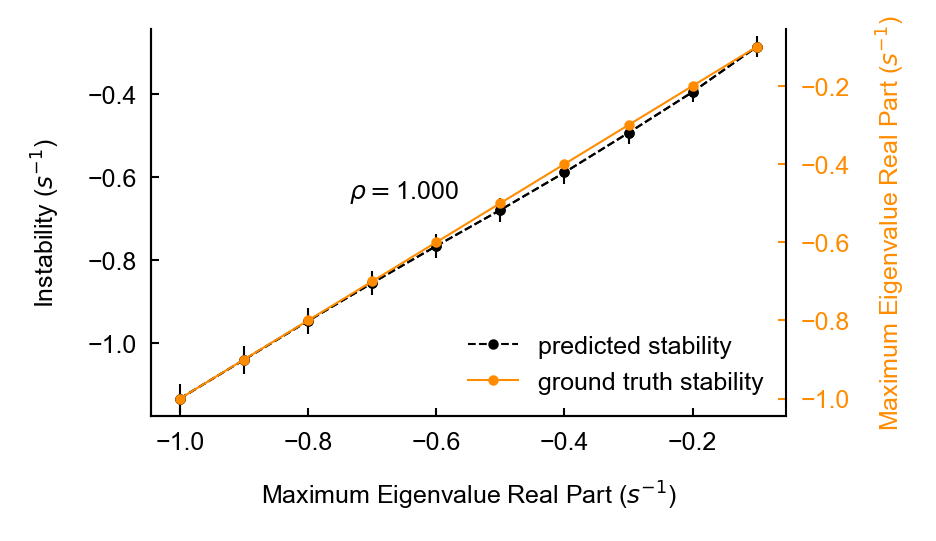

In [24]:
pred_color = 'orange'
markersize = 1.5
labelsize = 6

fig = plt.figure(figsize=(2.7295, 1.6756))

lns = []
lns += plt.plot(lams, ret_means, label='predicted stability', c='k', linestyle='--', marker='o', markersize=markersize)

ax = plt.gca()
ax2 = ax.twinx()

color = 'darkorange'

lns += ax2.plot(lams, lams, c=color, marker='o', label='ground truth stability', markersize=markersize)
ylim = ax.get_ylim()
# ax.fill_between(lams, ret_means - ret_means_se, ret_means + ret_means_se, color='k', alpha=0.4)
ax.errorbar(lams, ret_means, yerr=ret_means_se, c='k', linestyle='--', marker='o', markersize=markersize)
figure3_data = {'eigenvalues': lams, 'mean_predicted': ret_means, 'se_predicted': ret_means_se}
ax.set_ylim(ylim)

# ax.set_ylabel('Instability\n(Mean of Top 10%, $s^{-1}$)', fontsize=ylabel_fontsize)
ax.set_ylabel('Instability ($s^{-1}$)', fontsize=labelsize)
ax.set_xlabel('Maximum Eigenvalue Real Part ($s^{-1}$)', fontsize=labelsize)

# ax.text(-0.65, -0.5, f"Measuring Ground Truth Stability\nin Stochastic Linear Systems\n{num_samples*100/n:.1f}% partial observation\n" + fr"$\rho = ${scipy.stats.pearsonr(ret_means, lams)[0]:.3f}", ha='center', fontsize=title_fontsize)
ax.text(-0.65, -0.65, fr"$\rho = ${scipy.stats.pearsonr(ret_means, lams)[0]:.3f}", ha='center')
ax2.set_ylabel('Maximum Eigenvalue Real Part ($s^{-1}$)', color=color, fontsize=labelsize)

# ax.spines[['top']].set_visible(False)
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

# ax2.spines[['top']].set_visible(False)
# ax2.xaxis.set_ticks_position('bottom')
# ax2.yaxis.set_ticks_position('right')
ax2.spines[['right']].set_visible(True)
ax2.tick_params(axis='y', colors=color)

plt.legend(lns, [ln.get_label() for ln in lns], loc='lower right')
plt.savefig(os.path.join(img_save_dir, 'linear.pdf'), bbox_inches='tight', transparent=True)

bbox = fig.get_tightbbox(fig.canvas.get_renderer())
# Calculate width and height of the bounding box in inches
width_inches = (bbox.x1 - bbox.x0)
height_inches = (bbox.y1 - bbox.y0)
print(width_inches, height_inches)

plt.show()

In [26]:
scipy.io.savemat(os.path.join(data_save_dir, 'figure3_linear.mat'), figure3_data)